# TP2

**Objetivo:** Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov".

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 50 10% del area total del frame.
Para cada experimento se debe presentar:

Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

**Puntos extra:** Aplicar unsharp masking para expandir la zona de enfoque y devolver.

Ejemplo:

![image](https://github.com/user-attachments/assets/7b447ea7-95d5-4afb-b770-dc40a2f2a448)


### 1. Importamos las librerias necesarias.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

### 2. Función para calcular Sharpness basada en el paper.

In [6]:
def calculate_sharpness(input_image):
    """
    Calcula la métrica FM (Frequency Domain Image Blur Measure).
    """
    M, N = input_image.shape[:2]
    
    if len(input_image.shape) == 3:
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Step 1: Fourier Transform
    F = np.fft.fft2(input_image)
    
    # Step 2: Shift zero-frequency component to center
    Fc = np.fft.fftshift(F)
    
    # Step 3: Absolute value
    AF = np.abs(Fc)
    
    # Step 4: Maximum value
    M_val = np.max(AF)
    
    # Step 5: Threshold
    thres = M_val / 1000
    
    # Step 6: Count pixels greater than threshold
    TH = np.sum(AF > thres)
    
    # Step 7: Calculate FM
    FM = TH / (M * N)
    
    return FM

### 3. Procesamiento de video y carga de los frames.


In [15]:
video_path = 'focus_video.mov'

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("No se pudo abrir el video.")

sharpness_full_frame = []
sharpness_roi_frame = []
frames = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    height, width = frame.shape[:2]

    sharpness_full = calculate_sharpness(frame)

    roi_w, roi_h = int(width * 0.316), int(height * 0.316)  # sqrt(0.10) ≈ 0.316
    start_x = width // 2 - roi_w // 2
    start_y = height // 2 - roi_h // 2
    roi = frame[start_y:start_y+roi_h, start_x:start_x+roi_w]

    sharpness_roi = calculate_sharpness(roi)

    sharpness_full_frame.append(sharpness_full)
    sharpness_roi_frame.append(sharpness_roi)
    frames.append(frame.copy())

    frame_idx += 1

cap.release()

### 4. Normalización de las curvas


In [17]:
sharpness_full_frame_norm = np.array(sharpness_full_frame) / np.max(sharpness_full_frame)
sharpness_roi_frame_norm = np.array(sharpness_roi_frame) / np.max(sharpness_roi_frame)

# Índices de máximo sharpness
max_full_idx = np.argmax(sharpness_full_frame_norm)
max_roi_idx = np.argmax(sharpness_roi_frame_norm)


### 5. Visualización de resultados


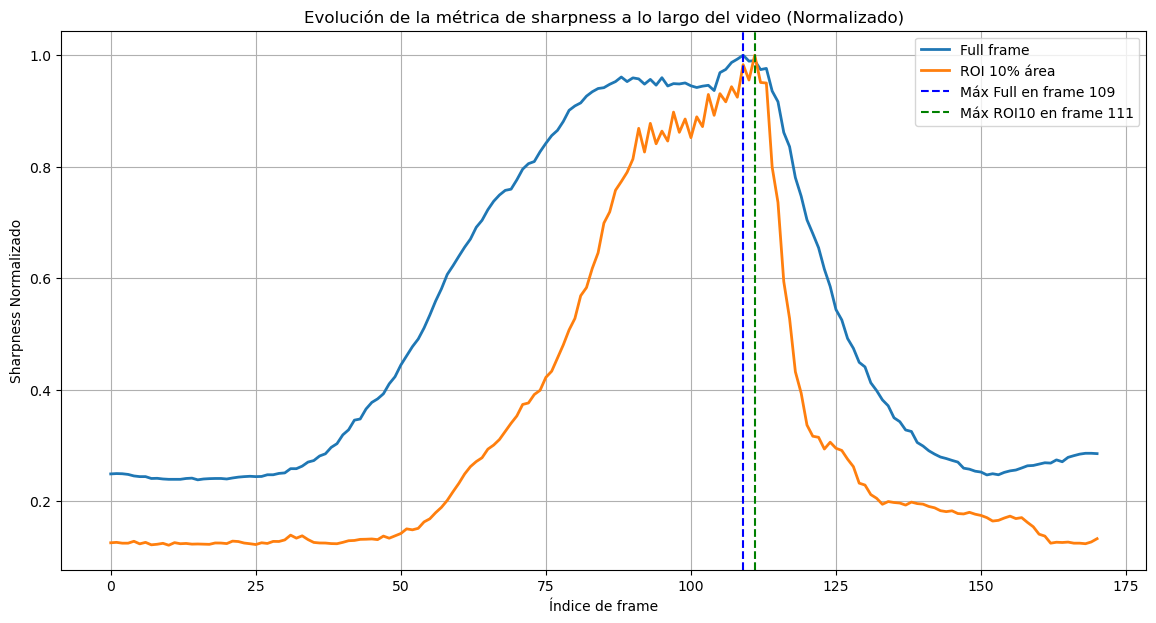

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(sharpness_full_frame_norm, label='Full frame', linewidth=2)
plt.plot(sharpness_roi_frame_norm, label='ROI 10% área', linewidth=2)

plt.axvline(max_full_idx, color='blue', linestyle='--', label=f'Máx Full en frame {max_full_idx}')
plt.axvline(max_roi_idx, color='green', linestyle='--', label=f'Máx ROI10 en frame {max_roi_idx}')

plt.title('Evolución de la métrica de sharpness a lo largo del video (Normalizado)')
plt.xlabel('Índice de frame')
plt.ylabel('Sharpness Normalizado')
plt.legend()
plt.grid(True)
plt.show()


## Punto extra

### Unsharp masking

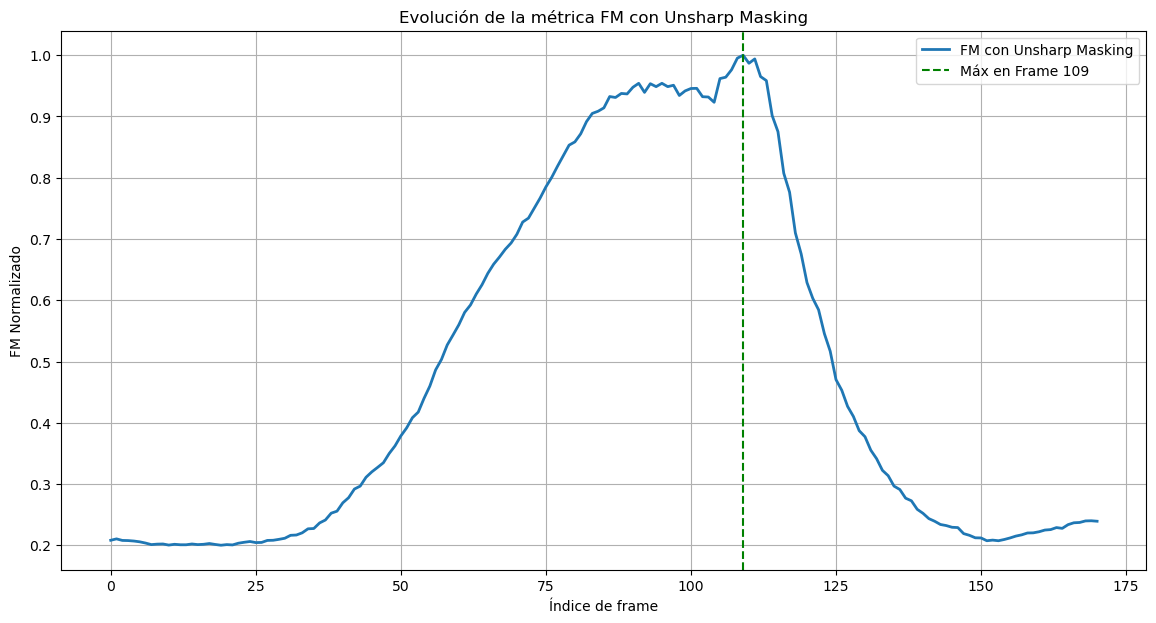

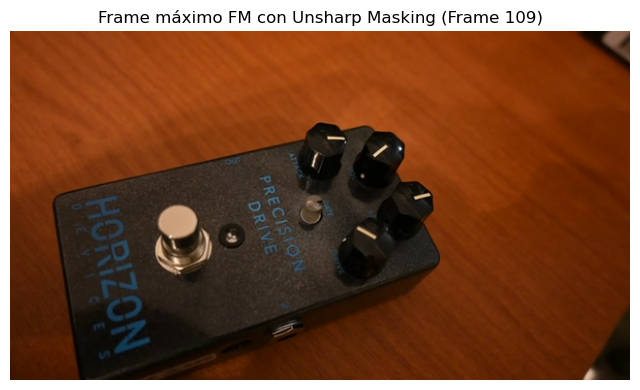

In [25]:
def calculate_FM_unsharp_normal(input_image, apply_unsharp=False, sigma=1.0):
    """
    Calcula la métrica FM aplicando opcionalmente unsharp masking.
    """
    if len(input_image.shape) == 3:
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    if apply_unsharp:
        blurred = cv2.GaussianBlur(input_image, (0, 0), sigma)
        input_image = cv2.addWeighted(input_image, 1.5, blurred, -0.5, 0)

    M, N = input_image.shape[:2]

    F = np.fft.fft2(input_image)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    M_val = np.max(AF)
    thres = M_val / 1000
    TH = np.sum(AF > thres)
    FM = TH / (M * N)
    
    return FM

# ------------------------------
# 3. Procesamiento de Video
# ------------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("No se pudo abrir el video.")

fm_normal_list = []
fm_unsharp_list = []
frames = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Guardar el frame
    frames.append(frame.copy())

    # Sharpness con Unsharp Masking
    fm_unsharp = calculate_FM_unsharp_normal(frame, apply_unsharp=True, sigma=1.0)
    fm_unsharp_list.append(fm_unsharp)

    frame_idx += 1

cap.release()

# ------------------------------
# 4. Normalización de curvas
# ------------------------------

fm_unsharp_list = np.array(fm_unsharp_list)


fm_unsharp_norm = fm_unsharp_list / np.max(fm_unsharp_list)

# Índices de máximo FM

max_idx_unsharp = np.argmax(fm_unsharp_norm)

# ------------------------------
# 5. Gráfico de FM Unsharp Masking
# ------------------------------
plt.figure(figsize=(14, 7))
plt.plot(fm_unsharp_norm, label='FM con Unsharp Masking', linewidth=2)
plt.axvline(max_idx_unsharp, color='green', linestyle='--', label=f'Máx en Frame {max_idx_unsharp}')
plt.title('Evolución de la métrica FM con Unsharp Masking')
plt.xlabel('Índice de frame')
plt.ylabel('FM Normalizado')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 6. Mostrar Frame de máximo FM
# ------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frames[max_idx_unsharp], cv2.COLOR_BGR2RGB))
plt.title(f'Frame máximo FM con Unsharp Masking (Frame {max_idx_unsharp})')
plt.axis('off')
plt.show()
